### Cancer Detection using Deep Learning 

In [2]:
import warnings 
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import shutil
import glob

In [3]:
# count number of images in the respective classes 0 - tumor 1 - healthy
ROOT_DIR = 'brain_tumor_dataset'
number_of_images = {}
for dir in os.listdir(ROOT_DIR):
    number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR,dir)))
print(number_of_images)

{'no': 98, 'yes': 155}


In [4]:
# split data into train - 70%, 15% for validation  and 15% test

In [5]:
def dataFolder(p, split):
    # Create train, validation, and test folder
    if not os.path.exists('./' + p):
        os.mkdir('./' + p)
        for dir in os.listdir(ROOT_DIR):
            os.makedirs('./' + p + '/' + dir)
            # Get all images in the directory
            images = os.listdir(os.path.join(ROOT_DIR, dir))
            # Determine the number of images to move
            num_to_move = math.floor(split * number_of_images[dir])
            if num_to_move > 0 and num_to_move <= len(images):
                selected_images = np.random.choice(images, size=num_to_move, replace=False)
                for img in selected_images:
                    o = os.path.join(ROOT_DIR, dir, img)
                    d = os.path.join('./' + p, dir)
                    shutil.copy(o, d)
                    # to keep working with original brain_tumor_dataset as it is less bruv 
                    # upon running train fxn validation and tests won't have enough images to split 
                    # comment os.remove(o) as i want to keep original dataset
                    # bad practice though
                    # os.remove(o)
            else:
                print(f"Not enough images to move for {dir} in {p} set")
    else:
        print(f"{p} folder already exists")




In [6]:
# train folder with 70% of data
dataFolder('train', 0.7)

train folder already exists


In [7]:
# validation folder with 1% of data
dataFolder('validation', 0.15)

validation folder already exists


In [8]:
# test folder with 25% of data
dataFolder('test', 0.15)

test folder already exists


### Model Build

In [9]:
import keras
from keras.layers import Conv2D, MaxPool2D, Flatten, Dropout, Dense, BatchNormalization, GlobalAvgPool2D
from keras.models import Sequential
from keras.preprocessing.image import load_img, img_to_array
from keras.src.legacy.preprocessing.image import ImageDataGenerator


In [10]:
# CNN Model
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)))

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Dropout(rate=0.25))

model.add(Flatten())
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(units=1, activation='sigmoid'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 220, 220, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 108, 108, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     5,537,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,635,361 (21.50 MB)

 Trainable params: 5,635,361 (21.50 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
# to input data into model
def preprocessingImages(path):
    """"input : path
    output : images"""
    image_data = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
    image =  image_data.flow_from_directory(directory=path, target_size=(224, 224), batch_size=32, class_mode='binary')

    return image

In [13]:
path = './train'
train_data = preprocessingImages(path)

Found 21 images belonging to 2 classes.


In [14]:
# to input data into model
def preprocessingImagesValidationandTest(path):
    """"input : path
    output : images"""
    image_data = ImageDataGenerator(rescale=1./255)
    image =  image_data.flow_from_directory(directory=path, target_size=(224, 224), batch_size=32, class_mode='binary')

    return image

In [15]:
path = './validation'
val_data = preprocessingImagesValidationandTest(path)

Found 11 images belonging to 2 classes.


In [16]:
path = './test'
test_data = preprocessingImagesValidationandTest(path)

Found 11 images belonging to 2 classes.


In [17]:
# Early stopping and model checkpoint
# Early stopping
from keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=3, verbose=1, mode='auto')

# Model Checkpoint
mc = ModelCheckpoint(monitor='val_accuracy', filepath='./best_model.keras', verbose=1, save_best_only=True, mode='auto')

cd = [es, mc]

### Model Training

In [18]:
hs = model.fit(train_data, 
                         steps_per_epoch=8, 
                         epochs=10,
                         verbose=1, 
                         validation_data=val_data, 
                         validation_steps=16, 
                         callbacks=cd)

Epoch 1/10
1/8 ━━━━━━━━━━━━━━━━━━━━ 3:27 30s/step - accuracy: 0.7619 - loss: 0.6840
Epoch 1: val_accuracy improved from -inf to 0.63636, saving model to ./best_model.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.7619 - loss: 0.6840 - val_accuracy: 0.6364 - val_loss: 2.8769
Epoch 2/10
1/8 ━━━━━━━━━━━━━━━━━━━━ 42s 6s/step - accuracy: 0.9524 - loss: 0.2001
Epoch 2: val_accuracy did not improve from 0.63636
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9524 - loss: 0.2001 - val_accuracy: 0.6364 - val_loss: 2.7552
Epoch 3/10
1/8 ━━━━━━━━━━━━━━━━━━━━ 33s 5s/step - accuracy: 0.9524 - loss: 0.2172
Epoch 3: val_accuracy did not improve from 0.63636
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 0.9524 - loss: 0.2172 - val_accuracy: 0.6364 - val_loss: 1.7858
Epoch 4/10
1/8 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - accuracy: 0.9524 - loss: 0.1362
Epoch 4: val_accuracy did not improve from 0.63636
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.9524 - loss: 0.1362 - val_accuracy:

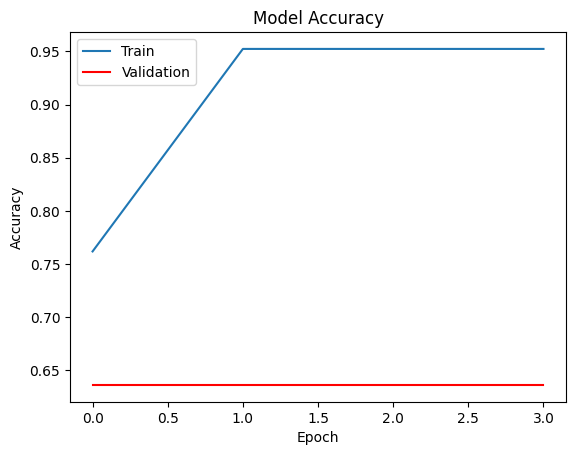

In [19]:
# Model Graphical INTERPRETATION
h = hs.history
h.keys()


plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'], c='red')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [22]:
# Model Accuracy
from keras.models import load_model
model = load_model('./best_model.keras')

In [23]:
acc = model.evaluate(test_data)[1]

print(f"the accuracy of the model is {acc*100} %")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6364 - loss: 3.4666
the accuracy of the model is 63.63636255264282 %


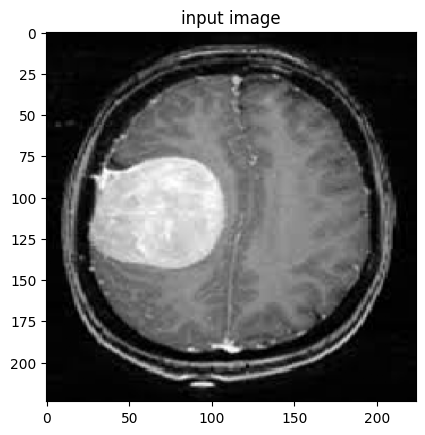

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Image has no tumor


In [26]:
path = './brain_tumor_dataset/yes/Y1.jpg'
img = load_img(path, target_size=(224, 224))
input_arr = img_to_array(img)/255

plt.imshow(input_arr)
plt.title("input image")
plt.show()


input_arr.shape

input_arr = np.expand_dims(input_arr, axis=0)
pred = model.predict(input_arr)[0][0]

pred

if pred == 0:
    print("Image has tumor")
else:
    print("Image has no tumor")

### Increase Model Accuracy

In [28]:
# can increase model accuracy by transfer learning or hyper parameter tuning(keras tuner)
from keras.layers import Flatten, Dense
from keras.models import Model, load_model
from keras.applications.mobilenet import MobileNet, preprocess_input

In [ ]:
base_model = MobileNet(input_shape=(224, 224, 3), include_top=False)
for layer in base_model.layers:
    layer.trainable = False
X = Flatten()(base_model.output)
X = Dense(units=1, activation='sigmoid')(X)
model = Model(base_model.input, X)
# can optimize with resprop
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

